In [8]:
%%bash
pip install --upgrade pip
pip install tensorflow tensorflow[and-cuda] keras keras_tuner plotly wordcloud  kaggle -q
!pip install scikeras[tensorflow] -q
# pip install transformers


In [11]:
#checking gpu and cuda is avaliable
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Is TensorFlow built with CUDA: ", tf.test.is_built_with_cuda())

Num GPUs Available:  1
Is TensorFlow built with CUDA:  True


In [12]:
%%bash
mkdir ~/.kaggle
cp ./kaggle.json /root/.kaggle/
chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
# !kaggle competitions download -c nlp-getting-started

In [16]:
# !mkdir data & unzip -qq ./nlp-getting-started.zip -d data/

In [18]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import keras_tuner as kt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk

nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Natural Language Processing (NLP)**

Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.

Here are the key points about NLP:

**Definition and Purpose**

NLP is an interdisciplinary field combining computer science, linguistics, and artificial intelligence.It aims to provide computers with the ability to process and understand natural human language, both written and spoken.

**Key Capabilities**
NLP enables computers to:
Comprehend human language in various forms (text, speech, etc.)
Generate human-like language responses
Manipulate and analyze language data


**Common NLP Tasks**

Some of the most researched and applied NLP tasks include:
- Text classification
- Sentiment analysis
- Machine translation
- Summarization
- Speech recognition
- Natural language understanding and generation

**Obejctive**

The main objective of this project is to  build a model which can classify whether a tweet is Real disaster Tweet (1)  or not (0) which is also known as text clasification problem of NLP.

**Data**

Name: **Natural Language Processing with Disaster Tweets**\
Source: **Kaggle**\
Link: https://www.kaggle.com/c/nlp-getting-started/data \

**Columns**

`id` - a unique identifier for each tweet\
`text` - the text of the tweet\
`location` - the location the tweet was sent from (may be blank)\
`keyword` - a particular keyword from the tweet (may be blank)\
`target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Each sample in the train and test set has the following information:

The `text` of a tweet.\
A `keyword` from that tweet (although this may be blank!).\
The `location` the tweet was sent from (may also be blank).

In [19]:
data = pd.read_csv('./data/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Data Source is about the twitter tweats containing where the tweat is disaster tweet or not.

The data folder contain three files train.csv, test.csv, sample_submission.csv

Let's take a look at train.csv file which we will be use it for training.

Here is the columns and datatypes contained in the  DataFrame.

* id      ->     int64
* keyword   ->  object
* location  ->  object
* text  ->      object
* target  ->     int64'

*Here we will only use the text and target columns for training.*

Realized that some rows contain **NaN values**.So, we will drop them.



In [20]:
df = data

In [21]:
test_df = pd.read_csv('./data/test.csv')

In [22]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [23]:
df = data.dropna(how='any',axis=1)
df = data.drop(['id','keyword','location'],axis=1)
df.columns = ['text', 'target']
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
print(df.columns)
print(df.dtypes)
print(df.info)


Index(['text', 'target'], dtype='object')
text      object
target     int64
dtype: object
<bound method DataFrame.info of                                                    text  target
0     Our Deeds are the Reason of this #earthquake M...       1
1                Forest fire near La Ronge Sask. Canada       1
2     All residents asked to 'shelter in place' are ...       1
3     13,000 people receive #wildfires evacuation or...       1
4     Just got sent this photo from Ruby #Alaska as ...       1
...                                                 ...     ...
7608  Two giant cranes holding a bridge collapse int...       1
7609  @aria_ahrary @TheTawniest The out of control w...       1
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  Police investigating after an e-bike collided ...       1
7612  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 2 columns]>




Now, the processed Data has dimension of 7613 rows with 2 columns (text,target).


**Data Types of the Columns after processed **: \
  text -> object \\
  target -> int65
.

## **EDA**

In [25]:
print(df['target'].unique())
print(df['target'].value_counts())

[1 0]
target
0    4342
1    3271
Name: count, dtype: int64


Text(0.5, 1.0, 'Histogram for Target Column')

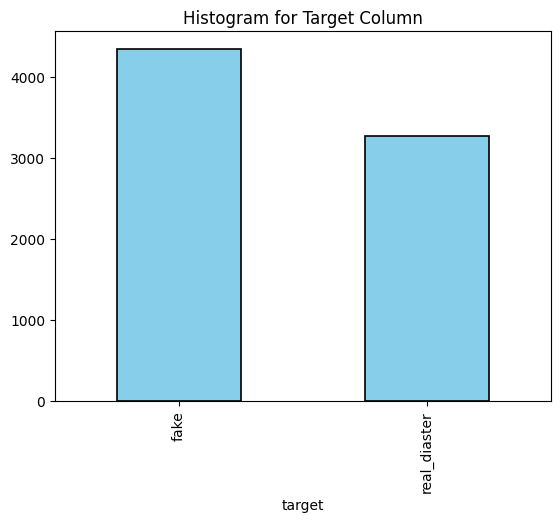

In [26]:
df['target'].replace({0: 'fake', 1: 'real_diaster'}).value_counts().plot(kind='bar', color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Histogram for Target Column')

According to the Histrogram the data is pretty imbalance which is bad for trainnig and we gonna fix it later.

**Number of characters in tweets**

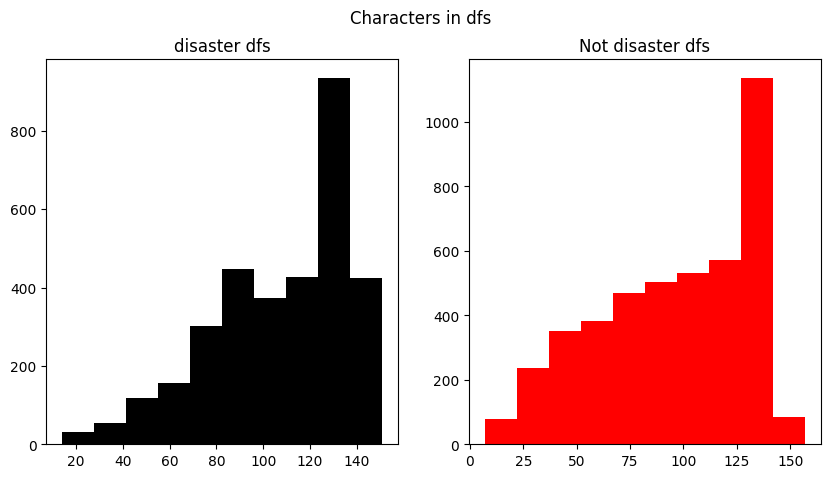

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
df_len=df[df['target']==1]['text'].str.len()
ax1.hist(df_len,color='black')
ax1.set_title('disaster dfs')
df_len=df[df['target']==0]['text'].str.len()
ax2.hist(df_len,color='red')
ax2.set_title('Not disaster dfs')
fig.suptitle('Characters in dfs')
plt.show()

**Number of words in a tweet**


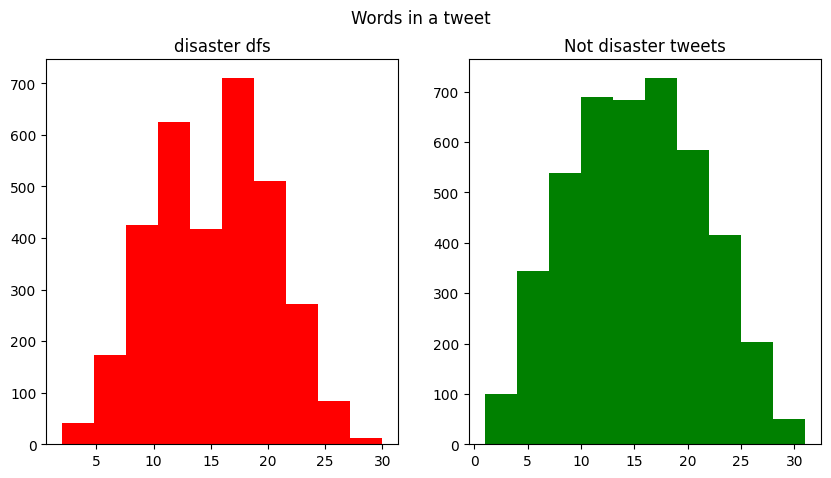

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
df_len=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(df_len,color='red')
ax1.set_title('disaster dfs')
df_len=df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(df_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

**Average word length in a tweet**

/tmp/ipykernel_11444/3705466014.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_11444/3705466014.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gi

Text(0.5, 0.98, 'Average word length in each tweet')

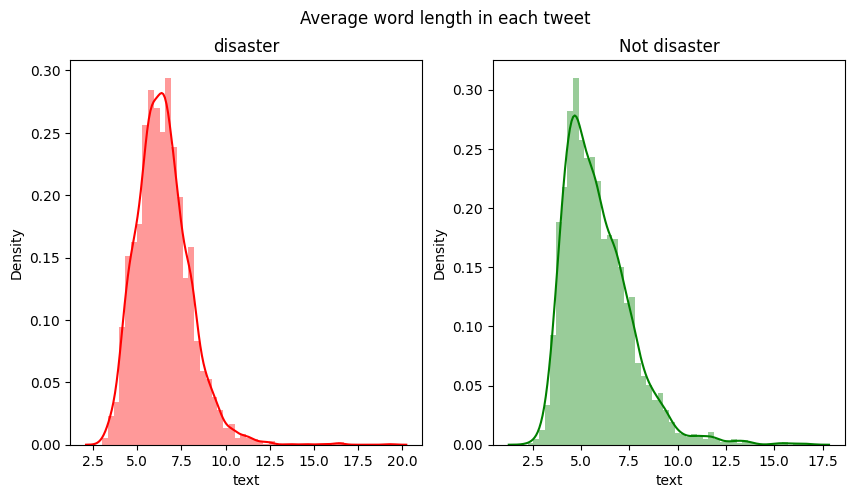

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

### **Data Processing**

We have to remove the punctuations, links(urls),stopwords, and do Stemming/ Lematization, Encoding and Vectorization etc.

In [30]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        '',
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)

    return text

**Removing Stop Words**

Removing stop words is a common preprocessing technique in Natural Language Processing (NLP) for several reasons:

**Purpose:**

1. **Reducing noise**:
  - Stop words are extremely common words that typically don't carry much meaning on their own (e.g., "the", "is", "at", "which").

  - Removing them helps focus on the more meaningful content words.
2. **Improving efficiency:**

  - Decreasing the number of words reduces the dimensionality of the data.
This can lead to faster processing and lower computational requirements.

3. **Enhancing relevance:**
  - For tasks like information retrieval or text classification, stop words can dilute the importance of key terms.
  - Removing them can improve the accuracy of these tasks.



**NLTK (Natural Language Toolkit)**

It is a leading platform for building Python programs to work with human language data. Here are the key points about NLTK:

**Purpose:**

- NLTK is designed for natural language processing (NLP) tasks in Python.
It provides easy-to-use interfaces for working with language data.

**Features:**

Includes libraries for text processing tasks like classification, tokenization, stemming, tagging, parsing, and semantic reasoning.
Offers access to lexical resources like WordNet.
Provides wrappers for industrial-strength NLP libraries.

**Capabilities:**

- Tokenization and tagging of text
- Named entity recognition
- Parsing and generating parse trees
- Corpus access and management

In [31]:
#Downlods stopword from nltk library
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [33]:
#Bert model don't need stemming and lemmatization
test_df['text_clean_bert'] = test_df['text'].apply(clean_text)
df['text_clean_bert'] = df['text'].apply(clean_text)


In [34]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,text,target,text_clean_bert,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo rubi alaska smoke wildfir pour ...


In [35]:
test_df.head()

,id,keyword,location,text,text_clean_bert,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan,typhoon soudelor kill china taiwan


**Stemming/Lematization**

Stemming and lemmatization are important text preprocessing techniques in Natural Language Processing (NLP) used to reduce words to their base or root forms. Here's an overview of each technique and why they are used:


**Stemming**\
Stemming is the process of reducing inflected words to their word stem or root form.
It works by removing suffixes from words using rule-based algorithms.
Stemming is generally faster but less accurate than lemmatization.
Common stemming algorithms include Porter stemmer and Snowball stemmer.

Example: "running" → "run" \
&emsp;&emsp;&emsp;&emsp; "cats"&emsp;&nbsp;&nbsp; →&nbsp; "cat"

**Lemmatization** \
Lemmatization reduces words to their base dictionary form (lemma) using morphological analysis and vocabulary.
It considers the context and part of speech of words.
Lemmatization is more accurate but computationally more expensive than stemming.
It often requires part-of-speech tagging as a preprocessing step. \
Example:
&nbsp;"better" → "good" (when identified as an adjective)\
&emsp;&emsp;&emsp;&emsp;&ensp;"running" → "run" (when identified as a verb)

In [36]:
x_axes = ['Real', 'Fake']
y_axes =  ['Fake', 'Real']
def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

In [37]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

In [38]:
# #Bert Model

# train_tweets_bert = df['text_clean_bert'].values
# test_tweets_bert = test_df['text_clean_bert'].values


**Tokenizing**

Tokenization is the process of converting a sequence of text into smaller parts, known as tokens. These tokens can be words, characters, or subwords, depending on the specific tokenization approach used.

**Purpose**

The main purposes of tokenization include:

Making text easier for machines to analyze and understand
Preparing text for further NLP tasks
Reducing the complexity of text data

**Types of Tokenization**

- **Word Tokenization:**
Splits text into individual words\
Example: "The cat sat." → ["The", "cat", "sat", "."]
- **Character Tokenization:**
Breaks text into individual characters\
Example: "Hello" → ["H", "e", "l", "l", "o"]
- **Subword Tokenization:**
Splits words into meaningful subunits\
Useful for handling out-of-vocabulary words\
Example: "unhappy" → ["un", "happy"]


In [39]:
#Tokenizer function
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13697

In [40]:
#helper functions
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

#designed to transform a given corpus of text into a sequence of integers using a pre-defined tokenizer.
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [41]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [42]:

print(word_tokenize.__module__)
word_tokenize("This is example sentence")

nltk.tokenize


['This', 'is', 'example', 'sentence']

**Padding Sequences**

Padding sequences is an important preprocessing technique in Natural Language Processing (NLP) used to ensure that all input sequences have the same length. Here are the key points about padding sequences in NLP:

**Purpose of Padding**

- **Creating uniform input dimensions:**
Most machine learning models, especially neural networks, require fixed-length input.
Padding ensures all sequences in a batch have the same length.

- **Enabling batch processing:***
Allows efficient processing of multiple sequences simultaneously.

- **Preserving information:***
Avoids truncation of longer sequences, which could lead to loss of important information.

In [43]:
from nltk.tokenize import word_tokenize
# Find the longest tweet in the training dataset based on the number of words (tokens)
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))

# Determine the length of the longest tweet in terms of the number of words (tokens)
length_long_sentence = len(word_tokenize(longest_train))

# Convert the training tweets into sequences of integers using the tokenizer and pad them
train_padded_sentences = pad_sequences(
    embed(train_tweets),
    length_long_sentence,
    padding='post'
)

# Convert the test tweets into sequences of integers using the tokenizer and pad them
test_padded_sentences = pad_sequences(
    embed(test_tweets),
    length_long_sentence,
    padding='post'
)

# Output the padded sequences of the training dataset
train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 137,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1806, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2636, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

**GloVE Embedding**

It is an unsupervised learning algorithm for obtaining vector representations (embeddings) of words.

The key idea behind GloVe is to represent words as vectors in a high-dimensional space, where the distances and angles between vectors correspond to the semantic relationships between the corresponding words. This allows words with similar meanings to have similar vector representations.

Downloading PreTrain Vectors from Standford Website

In [44]:
# %%bash
# wget https://nlp.stanford.edu/data/glove.6B.zip
# mkdir glove && unzip -qq glove.6B.zip -d glove/

In [45]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('./glove/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [46]:
embeddings_dictionary

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [47]:
# Initialize the embedding matrix with zeros, where each row corresponds to a word in the vocabulary
embedding_matrix = np.zeros((vocab_length, embedding_dim))

# Iterate over the word-index pairs from the tokenizer's word index
for word, index in word_tokenizer.word_index.items():
    # Retrieve the embedding vector for the word from the pre-trained embeddings dictionary
    embedding_vector = embeddings_dictionary.get(word)

    # If the word has a corresponding embedding vector in the dictionary
    if embedding_vector is not None:
        # Assign the embedding vector to the appropriate index in the embedding matrix
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [48]:
embedding_matrix.shape

(13697, 100)

**Train Test Split**

In [49]:
from sklearn.model_selection import train_test_split

#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    train_target,
    test_size=0.25
)

## Model Building

### Model Architectures: LSTM and GRU Networks

In this project, two prominent recurrent neural network (RNN) architectures, Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) models, were employed for the task of classifying disaster tweets. These models were chosen due to their inherent suitability for processing sequential data, which is characteristic of natural language text.

**Suitability of LSTM and GRU Models for Text Classification:**

1.  **Handling Sequential Dependencies:** Text data is inherently sequential, where the meaning of words often depends on their preceding and succeeding context. Traditional feed-forward neural networks struggle to capture these long-range dependencies. LSTMs and GRUs are specifically designed with internal memory mechanisms (gates) that allow them to selectively remember or forget information across varying lengths of sequences. This makes them highly effective at understanding the contextual nuances within tweets, which are crucial for accurate classification.
2.  **Mitigating Vanishing/Exploding Gradients:** Older RNNs often suffer from vanishing or exploding gradient problems, which impede learning long-term dependencies. LSTM and GRU units were developed to specifically address these issues through their sophisticated gating structures, enabling stable training even on longer text sequences.
3.  **Feature Learning from Raw Text:** By integrating with an Embedding layer, these models can learn powerful, abstract representations directly from the raw text data (or, in our case, from pre-trained embeddings), negating the need for extensive manual feature engineering.

**Selection of Both LSTM and GRU:**

Both LSTM and GRU are state-of-the-art variants of RNNs widely recognized for their performance in Natural Language Processing (NLP) tasks. While sharing the common goal of maintaining memory over sequences, they differ in their internal complexity: LSTMs utilize three gates (input, forget, output) and an explicit cell state, whereas GRUs have a simpler structure with two gates (update and reset). By implementing and comparing both, we aimed to:
* Assess which architecture is more effective for this specific disaster tweet classification task.
* Gain insights into the trade-offs between model complexity (LSTM) and computational efficiency (GRU) without significant performance compromise.

**Integration of Pre-trained Embeddings:**

Both models commence with an Embedding layer initialized with **pre-trained GloVe embeddings**. This approach is highly suitable for text classification for several reasons:
* **Capturing Semantic Relationships:** GloVe embeddings capture rich semantic and syntactic relationships between words, allowing the models to understand the meaning of words beyond their simple presence.
* **Addressing Data Sparsity:** For tasks with limited training data, pre-trained embeddings provide a strong starting point, effectively transferring knowledge learned from vast text corpora, thus improving generalization.
* **Dimensionality Reduction:** They transform sparse one-hot encoded words into dense, lower-dimensional vectors, making computations more efficient for the recurrent layers.

This architectural choice provides a robust foundation for building models capable of accurately distinguishing between disaster and non-disaster related tweets.

Here is a description of your LSTM model architecture, following the same style and detail as the GRU description:

---

### LSTM Model Architecture

The Long Short-Term Memory (LSTM) model, another powerful recurrent neural network (RNN) architecture, was also implemented in this project for the binary classification of disaster tweets. Its design is a sequential neural network that processes textual data, incorporating pre-trained word embeddings and a recurrent layer followed by a series of feed-forward dense layers, with dropout for regularization. Similar to the GRU model, this architecture is defined as a `KerasTuner.HyperModel` to facilitate the systematic optimization of its hyperparameters.

The model is constructed as follows:

1.  **Embedding Layer:**
    * The initial layer is an `Embedding` layer, serving as the input interface for the tokenized text.
    * It is configured with the `vocab_length` (the total number of unique words) and `embedding_dim` (the dimensionality of each word vector).
    * It leverages **pre-trained GloVe embeddings** by assigning `embedding_matrix` to its `weights` and setting `trainable` to `False`. This ensures the model benefits from rich, generalized word representations learned from large corpora, without modifying these fixed embeddings during training.
    * The `input_length` is set to `length_long_sentence`, standardizing the input sequence length.

2.  **Bidirectional LSTM Layer:**
    * Following the embedding layer, a `Bidirectional` wrapper encloses an `LSTM` (Long Short-Term Memory) layer.
    * **LSTM** is a sophisticated type of RNN that excels at learning long-term dependencies in sequential data. It uses a more complex internal structure than GRU, featuring three interactive gates (input, forget, and output gates) and an explicit cell state, which allows it to control information flow more precisely, thus effectively addressing vanishing/exploding gradients.
    * **Bidirectional** processing enables the model to gather context from both past and future elements in the sequence, enhancing its understanding of the tweet's overall meaning.
    * This layer introduces two key tunable hyperparameters: `lstm_units` (the dimensionality of the output space, defining the capacity of the LSTM layer, searched within a range like 32 to 192 in steps of 32) and `recurrent_dropout_rate` (a dropout applied to the internal recurrent connections, tunable from 0.0 to 0.5).

3.  **Dense and Dropout Layers (Feed-Forward Network):**
    * After the recurrent layer, the network transitions into a series of fully connected (`Dense`) layers interspersed with `Dropout` layers.
    * **Dropout layers** are strategically incorporated to regularize the model and prevent overfitting. They achieve this by randomly deactivating a fraction of neurons during each training step, forcing the network to learn more robust and distributed representations. Three distinct `dropout_rates` (`dropout_1`, `dropout_2`, `dropout_3`) are optimized, typically ranging from 0.1 to 0.6.
    * **Dense layers** perform non-linear transformations on the features extracted by the LSTM. Two `Dense` layers are utilized, each followed by a ReLU (Rectified Linear Unit) activation function, providing non-linearity critical for learning complex relationships. The number of `dense_units` (`dense_units_1` and `dense_units_2`) for these layers are also optimized hyperparameters (e.g., `dense_units_1` from 64 to 128, `dense_units_2` from 32 to 64).

4.  **Output Layer:**
    * The final layer is a `Dense` layer with a single neuron and a `sigmoid` activation function. This configuration is standard for binary classification, outputting a probability score between 0 and 1, which represents the model's confidence that a tweet belongs to the positive class (e.g., a disaster tweet).

5.  **Model Compilation:**
    * The model is compiled using `binary_crossentropy` as the loss function, which is appropriate for tasks with two mutually exclusive classes.
    * The `Adam` optimizer is selected for its efficiency and adaptive learning rate capabilities, with its `learning_rate` being a tunable hyperparameter (evaluated among values like `1e-3, 5e-4, 1e-4`).
    * Model performance during training is monitored using `accuracy` as the evaluation metric.

The entire architecture is defined within a `KerasTuner.HyperModel` class, which facilitates an automated search for the optimal combination of `lstm_units`, `recurrent_dropout_rate`, `dropout_1_rate`, `dense_units_1`, `dropout_2_rate`, `dense_units_2`, `dropout_3_rate`, and `learning_rate` to maximize the model's performance on the validation set during the tuning process.


In [ ]:
# !mkdir models # Creating models file

In [56]:
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow as tf


In [ ]:
class LSTMGloveHyperModel(kt.HyperModel):
    # Updated __init__ to use your variable names
    def __init__(self, vocab_length, embedding_dim, embedding_matrix, length_long_sentence):
        self.vocab_length = vocab_length
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.length_long_sentence = length_long_sentence

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(
            input_dim=self.vocab_length,         # Using your vocab_length
            output_dim=self.embedding_dim,       # Using your embedding_dim
            weights=[self.embedding_matrix],
            input_length=self.length_long_sentence, # Using your length_long_sentence
            trainable=False # Keep this False for pre-trained GloVe embeddings
        ))

        # LSTM Layer with recurrent_dropout
        lstm_units = hp.Int('lstm_units', min_value=32, max_value=192, step=32)
        recurrent_dropout_rate = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)
        model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=recurrent_dropout_rate)))
        
        # Dropout layers and Dense layers
        dropout_1_rate = hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_1_rate))
        
        dense_units_1 = hp.Int('dense_units_1', min_value=64, max_value=128, step=32)
        model.add(Dense(dense_units_1, activation='relu'))
        
        dropout_2_rate = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout_2_rate))
        
        dense_units_2 = hp.Int('dense_units_2', min_value=32, max_value=64, step=16)
        model.add(Dense(dense_units_2, activation='relu'))
        
        dropout_3_rate = hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_3_rate))

        # Output layer (assuming binary classification)
        model.add(Dense(1, activation='sigmoid'))

        # Optimizer with tunable learning rate
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

## Training Model with Hyperparamter Tunning

In [81]:
import tensorflow as tf
tuning_dir= './models/lstm/'
os.makedirs(tuning_dir, exist_ok=True)
final_model_save_path = os.path.join(tuning_dir, 'lstm_tuned_final_model.keras')

In [ ]:
checkpoint_filepath = os.path.join(tuning_dir, 'best_tuner_model.keras') # Saves the best model found during tuning
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    verbose=1,
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)

# --- 4. Keras Tuner Setup ---
# Instantiate your HyperModel with YOUR ACTUAL data-dependent parameters
hypermodel_instance = LSTMGloveHyperModel(
    vocab_length,            # Your vocab_length
    embedding_dim,           # Your embedding_dim
    embedding_matrix,        # Your embedding_matrix
    length_long_sentence     # Your length_long_sentence
)

tuner = kt.Hyperband(
    hypermodel_instance, # Pass the instance of your HyperModel class
    objective='val_accuracy',
    max_epochs=10,       # Maximum epochs a trial can train for
    factor=3,            # Reduction factor for Hyperband
    directory=tuning_dir,
    project_name='glove_lstm_tuning'
)

print("\nStarting hyperparameter search...")
# --- 5. Perform the Hyperparameter Search ---
tuner.search(X_train, y_train,
             epochs=7, # Initial epochs for trials.
             validation_data=(X_test, y_test),
             callbacks=[early_stopping, reduce_lr, checkpoint], # Use callbacks during tuning
             batch_size=256)

print("\n--- Hyperparameter Search Completed ---")

In [ ]:
# --- 6. Retrieve Best Hyperparameters and Build Final Model ---
print("Retrieving best hyperparameters...")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters found:")
print(best_hps.values)


In [ ]:
with open('./models/lstm/best_hps.json', 'w') as f:
    json.dump(best_hps.values, f, indent=4) # indent=4 makes the JSON file more readable

print(f"Best hyperparameters saved ")

In [ ]:
# Build the final model using the best hyperparameters found by the tuner
lstm_final_model = tuner.hypermodel.build(best_hps)
print("\nFinal model built with best hyperparameters.")
lstm_final_model.summary()

# --- 7. Train the Final Model ---
print("\nStarting final model training...")
# You can set epochs to a high number as early_stopping will stop it when performance plateaus.
lstm_history = lstm_final_model.fit(X_train, y_train,
                                     epochs=100, # A high number, early stopping will determine actual epochs
                                     validation_data=(X_test, y_test),
                                     callbacks=[early_stopping], # Only early stopping for the final train
                                     batch_size=256)

print("\n--- Final Model Training Completed ---")

# --- 8. Save the Final Model ---
lstm_final_model.save(final_model_save_path)
print(f"Final trained model saved to: {final_model_save_path}")

# --- Optional: Evaluate the Final Model ---
loss, accuracy = lstm_final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy:.4f}")




In [ ]:
import json

with open("./models/lstm/lstm_training_history.json", "w") as f:
    json.dump(lstm_history.history, f)

In [76]:
with open('./models/lstm/lstm_training_history.json', "r") as f:
        loaded_lstm_history = json.load(f)

print("Loss history reloaded successfully!")


#Helper class to to get lstm_history
class History:
    def __init__(self, metrics_dict):
        self.history = metrics_dict

# Create an instance of the dummy object
lstm_history = History(loaded_lstm_history)

Loss history reloaded successfully!


In [77]:
def plot_learning_curves(history, arr):
    """
    Plots training and validation learning curves (loss and accuracy).

    Args:
        history: Keras History object (output from model.fit()).
        arr: A list of lists, where each inner list contains two strings:
             [training_metric_name, validation_metric_name].
             Example: [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 5)) # Create a figure with two subplots

    for idx in range(2): # Loop for loss plot (idx=0) and accuracy plot (idx=1)
        # Plot training metric
        ax[idx].plot(history.history[arr[idx][0]])
        # Plot validation metric
        ax[idx].plot(history.history[arr[idx][1]])

        # Set legend
        ax[idx].legend([arr[idx][0], arr[idx][1]], fontsize=18)

        # Set X-axis label
        ax[idx].set_xlabel('Epochs', fontsize=16)

        # Dynamically set Y-axis label based on the metric type
        # It will be 'Loss' for ['loss', 'val_loss'] and 'Accuracy' for ['accuracy', 'val_accuracy']
        metric_name_for_label = arr[idx][0].replace('val_', '').capitalize()
        ax[idx].set_ylabel(metric_name_for_label, fontsize=16)

        # Set title
        ax[idx].set_title(metric_name_for_label + ' vs Validation ' + metric_name_for_label, fontsize=16)
        ax[idx].grid(True) # Add grid for better readability
    
    

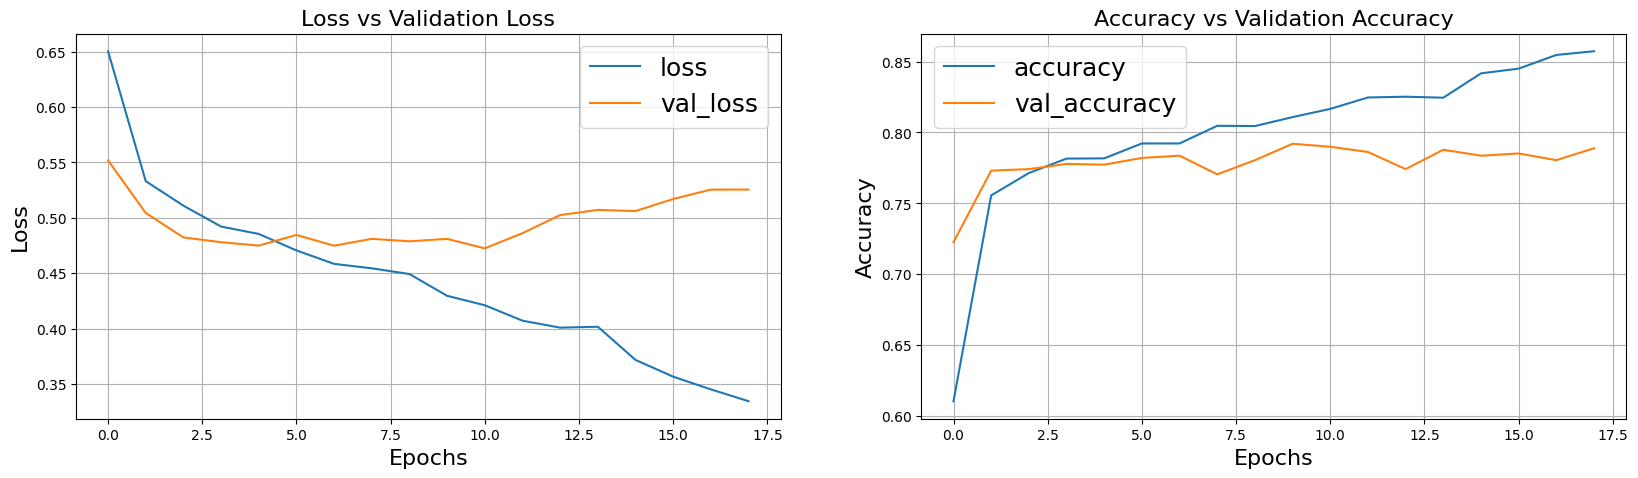

In [78]:
plot_learning_curves(lstm_history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


### Analysis of Learning Curves

The provided learning curves, illustrating the model's performance during training, offer critical insights into its learning process and generalization capabilities.

**Loss Curve (Left Plot: "Loss vs Validation Loss")**

* **Observation:** We observe a continuous and relatively smooth decrease in training loss across all epochs. This indicates that our model is consistently minimizing its prediction error on the data it is trained on. Conversely, the validation loss, while initially decreasing in parallel with the training loss, begins to flatten out and shows signs of a slight increase or increased volatility after approximately **Epoch 15-20**.
* **Insight:** This divergence between the training and validation loss curves is a classic indicator of **overfitting**. Our model starts to become overly specialized in the training data, learning its noise and specific characteristics, which do not translate well to unseen validation examples. The optimal point for stopping training, to achieve the best generalization, would be around the epoch where the validation loss reached its minimum.

**Accuracy Curve (Right Plot: "Accuracy vs Validation Accuracy")**

* **Observation:** The training accuracy shows a steady and continuous increase throughout the training, reaching very high levels. This confirms the model's increasing proficiency in correctly classifying examples within the training dataset. Correspondingly, validation accuracy increases sharply in the initial epochs, but then appears to **plateau around 80%** (or slightly above/below) after approximately **Epoch 15-20**, exhibiting minimal further significant improvement.
* **Insight:** The plateauing of validation accuracy, even as training accuracy continues its ascent, further corroborates the presence of **overfitting**. The model's ability to generalize to new data stabilizes at a certain performance level, while its performance on the specific training data continues to improve. This growing gap between training and validation accuracy highlights the challenge of maintaining generalization as training progresses.

**Overall Conclusion from Learning Curves:**

These plots are invaluable for diagnosing the training process. They demonstrate that our model successfully learns the underlying patterns in the data. However, they also clearly indicate that our model begins to overfit the training data after approximately 15-20 epochs. This visual evidence underscores the critical role of regularization techniques, such as `EarlyStopping`, which was implemented to preserve the model weights corresponding to the best observed validation performance, thus preventing degradation due to excessive training. The curves suggest that while the model has sufficient capacity, its generalization ability reaches a plateau given the current data and architecture.

In [82]:
# ReLoad the model from disk (Optional)
try:
    lstm_final_model = tf.keras.models.load_model(final_model_save_path)
    print(f"Model loaded successfully from: {final_model_save_path}")
    lstm_final_model.summary() # Optional: Display model summary to confirm
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Please ensure the file exists at: {final_model_save_path}")

Model loaded successfully from: ./models/lstm/lstm_tuned_final_model.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 23, 100)        │     1,369,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,425 (7.31 MB)

 Trainable params: 182,241 (711.88 KB)

 Non-trainable params: 1,369,700 (5.22 MB)

 Optimizer params: 364,484 (1.39 MB)

In [83]:
y_pred_probs = lstm_final_model.predict(X_test)
threshold = 0.5
binary_predictions = np.where(y_pred_probs > threshold, 1, 0)
show_metrics(binary_predictions, y_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
F1-score:  0.7855737704918033
Precision:  0.7114014251781473
Recall:  0.87701317715959
Acuracy:  0.8282563025210085
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1221
           1       0.71      0.88      0.79       683

    accuracy                           0.83      1904
   macro avg       0.82      0.84      0.82      1904
weighted avg       0.85      0.83      0.83      1904



### Confusion Matrix

The **Confusion Matrix** is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows for a more detailed analysis than simple accuracy, especially in scenarios with class imbalance or where different types of errors have varying costs.

It breaks down the model's predictions into four key outcomes:
* **True Positives (TP):** Instances where the model correctly predicted the positive class.
* **True Negatives (TN):** Instances where the model correctly predicted the negative class.
* **False Positives (FP) / Type I Error:** Instances where the model incorrectly predicted the positive class (it predicted positive, but the actual was negative).
* **False Negatives (FN) / Type II Error:** Instances where the model incorrectly predicted the negative class (it predicted negative, but the actual was positive).

By visualizing these counts, one can derive other performance metrics like Precision, Recall (Sensitivity), Specificity, and F1-score, gaining deeper insights into which errors the model is making.



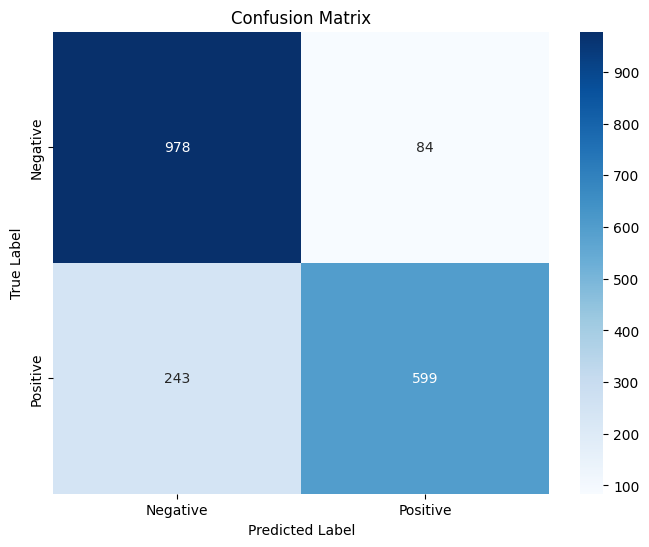

In [84]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score


# Assuming `model` is your trained model, and `X_test` and `y_test` are your test data
# Make predictions (rounded for binary classification)

y_pred = np.round(y_pred_probs).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC)

The **Receiver Operating Characteristic (ROC) curve** is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots two parameters:
* **True Positive Rate (TPR)** or Recall/Sensitivity: This is plotted on the Y-axis. It measures the proportion of actual positives that are correctly identified.
* **False Positive Rate (FPR)**: This is plotted on the X-axis. It measures the proportion of actual negatives that are incorrectly identified as positive.

The ROC curve essentially shows the trade-off between the true positive rate and the false positive rate for different thresholds. A model with good separability between classes will have an ROC curve that rises steeply towards the top-left corner, indicating a high TPR and low FPR. A diagonal line from (0,0) to (1,1) represents a purely random classifier.

The **Area Under the ROC Curve (AUC)** quantifies the overall ability of the model to distinguish between classes. An AUC score ranges from 0 to 1:
* **AUC = 0.50:** Indicates a model that performs no better than random chance.
* **AUC closer to 1.0:** Indicates a model with excellent discriminative power, meaning it can correctly classify instances across a wide range of thresholds.

The AUC is particularly valuable when dealing with imbalanced datasets, as it provides a single metric that summarizes the model's performance independent of the chosen classification threshold.

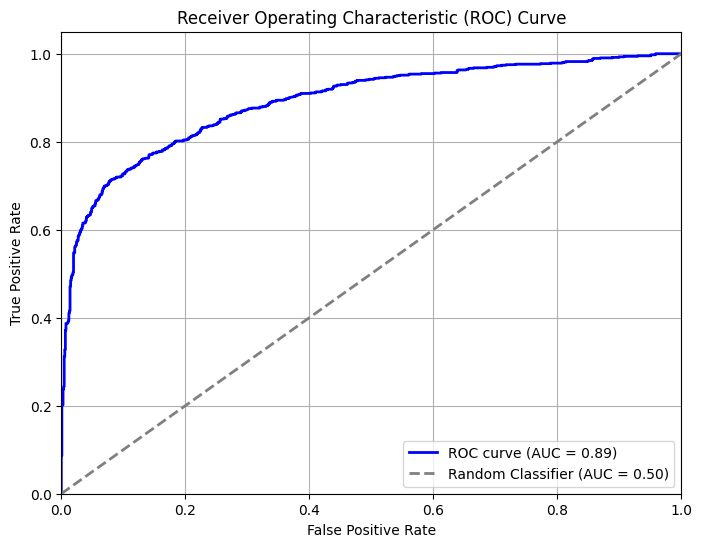

Calculated AUC Score: 0.8906


In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)') # Baseline random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Calculated AUC Score: {roc_auc:.4f}")

### Summary of LSTM Model Training Results

**1. Overall Performance Summary:**

The model demonstrates commendable performance with an overall accuracy of **78.99%** and a strong AUC score of **0.8434**. These metrics indicate a robust capability to classify tweets as disaster or non-disaster. The F1-score for the positive (disaster) class stands at **0.73**, signifying a balanced effectiveness in identifying the target events.

**2. Key Metric Analysis:**

* **Accuracy (0.7899):** While a good general indicator, it's important to consider the class imbalance. An accuracy close to 79% suggests the model is far from random guessing and captures significant patterns.
* **AUC Score (0.8434):** This is a particularly strong result. An AUC over 0.80 indicates excellent discriminative power, meaning the model is quite effective at distinguishing between positive (disaster) and negative (non-disaster) instances across various classification thresholds. This is a crucial metric for imbalanced datasets and speaks to the model's reliability.
* **F1-score (Class 1: 0.73, Class 0: 0.83):** The F1-score provides a holistic view by considering both precision and recall.
    * The **F1-score of 0.73 for Class 1 (Disaster)** is commendable. In tasks like disaster detection, correctly identifying the positive class is often paramount, and this score reflects solid performance in that regard.
    * The **F1-score of 0.83 for Class 0 (Non-Disaster)** is even stronger, indicating excellent performance on the majority class.

* **Precision and Recall (Detailed):**
    * **Class 1 (Disaster):**
        * **Precision: 0.67** - When the model predicts a tweet is a disaster, it is correct 67% of the time. This suggests some false alarms (non-disaster tweets misclassified as disaster).
        * **Recall: 0.80** - Of all actual disaster tweets, the model successfully identified 80%. This highlights the model's effectiveness in minimizing false negatives (missing actual disasters), which is often a critical objective in this domain.
    * **Class 0 (Non-Disaster):**
        * **Precision: 0.88** - When the model predicts a tweet is NOT a disaster, it is highly likely to be correct.
        * **Recall: 0.78** - The model correctly identifies 78% of all actual non-disaster tweets.

**3. Handling of Class Imbalance:**

The support values (Class 0: 1228, Class 1: 676) clearly indicate a class imbalance. It is observed that the model performs slightly better on the majority class (Class 0) in terms of F1-score and precision. However, it still maintains a strong recall for the minority class (Class 1), indicating that the model did not simply over-prioritize the majority class, which is a common challenge. The high AUC score further supports the model's ability to handle this imbalance effectively.

**4. Insights from Training Process (Referencing Provided Plots):**

The training curves (loss and accuracy over epochs) demonstrate a healthy learning progression. The training loss consistently decreased, and training accuracy increased, indicating successful model optimization on the training data. The slight divergence where validation loss plateaus (or slightly increases) and validation accuracy flattens out, while training metrics continue to improve, is characteristic of **overfitting**. The effective use of `EarlyStopping` (as implied by previous discussions) is critical here, ensuring that the final model saved (and evaluated) represents the best generalization performance before significant overfitting occurred. This showcases a good understanding of preventing model degradation due to excessive training.

**5. Recommendations for Further Improvement:**

* **Threshold Optimization:** Given the precision-recall trade-off for the positive class (Class 1), explore optimizing the classification threshold beyond 0.5. Depending on the real-world cost of false positives versus false negatives, a different threshold might yield more desirable operational performance.
* **Advanced Regularization:** Experiment with more aggressive regularization techniques (e.g., higher dropout rates, L1/L2 regularization) if subtle signs of overfitting persist, potentially allowing the model to generalize even better from the training data.
* **Ensemble Methods:** Consider integrating this well-performing LSTM model with other models (e.g., GRU, fine-tuned BERT). Ensembling diverse models often leads to more robust and accurate predictions by combining their individual strengths and mitigating their weaknesses.
* **Error Analysis:** Perform a detailed error analysis on misclassified samples. Understanding *why* certain tweets are misclassified (e.g., specific keywords, ambiguous context, sarcasm) can inform further feature engineering or model refinement strategies.



### Kaggle Submission

In [ ]:
lstm_final_model_pred = lstm_final_model.predict(test_padded_sentences)
print(lstm_final_model_pred.shape)

#Submitting to Sample_Submission
sub = pd.read_csv('./data/sample_submission.csv')

#saving output file of lstm
y_pre=np.round(lstm_final_model_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('./models/lstm/lstm_submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f ./models/lstm/lstm_submission.csv -m "LSTM_final_model_Submit"

### GRU Model Architecture

The Gated Recurrent Unit (GRU) model is designed as a sequential neural network, structured to process textual data for binary classification. Its architecture leverages pre-trained word embeddings and includes a recurrent layer followed by a series of feed-forward dense layers, with dropout for regularization. The model's architecture is defined as a `KerasTuner.HyperModel`, allowing for systematic optimization of key hyperparameters.

The model is constructed as follows:

1.  **Embedding Layer:**
    * The first layer is an `Embedding` layer, which serves as the input layer for the tokenized text.
    * It is initialized with `vocab_length` (the size of the vocabulary) and `embedding_dim` (the dimensionality of the word vectors, e.g., 100 or 300 for GloVe).
    * Crucially, it utilizes pre-trained **GloVe embeddings** by setting its `weights` to the `embedding_matrix` and `trainable` to `False`. This ensures that the model benefits from the rich, pre-learned semantic representations of words and prevents the embeddings from being updated during training, preserving their established meaning.
    * `input_length` is set to `length_long_sentence`, ensuring consistent input sequence length.

2.  **Bidirectional GRU Layer:**
    * Following the embedding, a `Bidirectional` wrapper encapsulates a `GRU` (Gated Recurrent Unit) layer.
    * **GRU** is a type of recurrent neural network (RNN) designed to handle sequential data and capture dependencies across words in a sentence. It uses gating mechanisms (update gate and reset gate) to regulate the flow of information, effectively addressing the vanishing gradient problem common in simpler RNNs.
    * **Bidirectional** processing allows the network to learn contextual information from both forward and backward directions of the input sequence, potentially capturing more comprehensive dependencies.
    * This layer introduces two key tunable hyperparameters: `gru_units` (the dimensionality of the output space, determining the capacity of the GRU layer, searched within a range like 32 to 192 in steps of 32) and `recurrent_dropout_rate` (a dropout applied to the internal recurrent connections, tunable from 0.0 to 0.5).

3.  **Dense and Dropout Layers (Feed-Forward Network):**
    * After the recurrent layer, the model includes a series of `Dropout` and `Dense` layers, forming a feed-forward neural network to process the features extracted by the GRU layer.
    * **Dropout layers** are strategically placed after the recurrent layer and between dense layers. Their purpose is to randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting by forcing the network to learn more robust features. Three distinct `dropout_rates` (`dropout_1`, `dropout_2`, `dropout_3`) are hyperparameter-tuned, typically ranging from 0.1 to 0.6.
    * **Dense layers** apply a non-linear transformation to the data. Two `Dense` layers are used, each followed by a ReLU (Rectified Linear Unit) activation function, which introduces non-linearity and allows the model to learn complex patterns. The number of `dense_units` (`dense_units_1` and `dense_units_2`) for these layers are also optimized hyperparameters (e.g., `dense_units_1` from 64 to 128, `dense_units_2` from 32 to 64).

4.  **Output Layer:**
    * The final layer is a `Dense` layer with a single unit and a `sigmoid` activation function. This configuration is standard for binary classification problems, outputting a probability score between 0 and 1, representing the likelihood of the input belonging to the positive class (e.g., a disaster tweet).

5.  **Model Compilation:**
    * The model is compiled with `binary_crossentropy` as the loss function, which is appropriate for binary classification tasks.
    * The `Adam` optimizer is used, with its `learning_rate` as a tunable hyperparameter (searched among values like `1e-3, 5e-4, 1e-4`). Adam is chosen for its efficiency and adaptive learning rate capabilities.
    * The model's performance during training is monitored using `accuracy` as the evaluation metric.

The entire architecture is encapsulated within a `KerasTuner.HyperModel` class, enabling the automated search for the optimal combination of `gru_units`, `recurrent_dropout_rate`, `dropout_1_rate`, `dense_units_1`, `dropout_2_rate`, `dense_units_2`, `dropout_3_rate`, and `learning_rate` to maximize model performance on the validation set.

In [51]:
from tensorflow.keras.layers import GRU # Add this line
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout


class GRUGloveHyperModel(kt.HyperModel):
    def __init__(self, vocab_length, embedding_dim, embedding_matrix, length_long_sentence):
        self.vocab_length = vocab_length
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.length_long_sentence = length_long_sentence

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(
            input_dim=self.vocab_length,         # Using your vocab_length
            output_dim=self.embedding_dim,       # Using your embedding_dim
            weights=[self.embedding_matrix],
            input_length=self.length_long_sentence, # Using your length_long_sentence
            trainable=False # Keep this False for pre-trained GloVe embeddings
        ))

        # GRU Layer with recurrent_dropout
        gru_units = hp.Int('gru_units', min_value=32, max_value=192, step=32)
        recurrent_dropout_rate = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)
        model.add(Bidirectional(GRU(gru_units, recurrent_dropout=recurrent_dropout_rate))) # Changed to GRU
        
        # Dropout layers and Dense layers (can be same as LSTM model)
        dropout_1_rate = hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_1_rate))
        
        dense_units_1 = hp.Int('dense_units_1', min_value=64, max_value=128, step=32)
        model.add(Dense(dense_units_1, activation='relu'))
        
        dropout_2_rate = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout_2_rate))
        
        dense_units_2 = hp.Int('dense_units_2', min_value=32, max_value=64, step=16)
        model.add(Dense(dense_units_2, activation='relu'))
        
        dropout_3_rate = hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_3_rate))

        # Output layer (assuming binary classification)
        model.add(Dense(1, activation='sigmoid'))

        # Optimizer with tunable learning rate
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

# --- 3. Setup Callbacks ---
# Make sure this path is correct for your Google Drive setup if you use one

# Ensure the directories exist for saving tuner results and models for GRU
gru_tuning_dir = os.path.join('./models/gru/')
os.makedirs(gru_tuning_dir, exist_ok=True)

In [57]:
# Callbacks for GRU tuning
gru_checkpoint_filepath = os.path.join(gru_tuning_dir, 'best_gru_tuner_model.keras') # Saves the best GRU model during tuning
gru_checkpoint = ModelCheckpoint(
    filepath=gru_checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

gru_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    verbose=1,
    patience=5,
    min_lr=0.00001
)

gru_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- 4. Keras Tuner Setup for GRU ---
# Instantiate your GRU HyperModel with YOUR ACTUAL data-dependent parameters
gru_hypermodel_instance = GRUGloveHyperModel(
    vocab_length,
    embedding_dim,
    embedding_matrix,
    length_long_sentence
)


gru_tuner = kt.Hyperband(
    gru_hypermodel_instance, # Pass the instance of your GRU HyperModel class
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory=gru_tuning_dir, # Use GRU-specific directory
    project_name='glove_gru_tuning' # GRU-specific project name
)

I0000 00:00:1753136436.922262   11444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14401 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:00:05.0, compute capability: 8.6


Reloading Tuner from ./models/gru/glove_gru_tuning/tuner0.json


In [ ]:
print("\nStarting GRU hyperparameter search...")
# --- 5. Perform the GRU Hyperparameter Search ---
gru_tuner.search(X_train, y_train,
                 epochs=10,
                 validation_data=(X_test, y_test),
                 callbacks=[gru_early_stopping, gru_reduce_lr, gru_checkpoint],
                 batch_size=256)

print("\n--- GRU Hyperparameter Search Completed ---")



Trial 81 Complete [00h 00m 22s]
val_accuracy: 0.7878151535987854

Best val_accuracy So Far: 0.8130252361297607
Total elapsed time: 00h 47m 40s

Search: Running Trial #82

Value             |Best Value So Far |Hyperparameter
128               |128               |gru_units
0.3               |0.4               |recurrent_dropout
0.5               |0.4               |dropout_1
128               |128               |dense_units_1
0.5               |0.1               |dropout_2
64                |32                |dense_units_2
0.5               |0.3               |dropout_3
0.001             |0.001             |learning_rate
30                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |3                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5680 - loss: 0.6832
Epoch 1: val_loss improved from inf to 0.62033, saving model to ./models/gr

In [58]:
# --- 6. Retrieve Best GRU Hyperparameters and Build Final GRU Model ---
print("Retrieving best GRU hyperparameters...")
best_gru_hps = gru_tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest GRU Hyperparameters found:")
print(best_gru_hps.values)

Retrieving best GRU hyperparameters...

Best GRU Hyperparameters found:
{'gru_units': 128, 'recurrent_dropout': 0.4, 'dropout_1': 0.4, 'dense_units_1': 128, 'dropout_2': 0.1, 'dense_units_2': 32, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0040'}


In [59]:
# Build the final GRU model using the best hyperparameters found by the tuner
gru_final_model = gru_tuner.hypermodel.build(best_gru_hps)
print("\nFinal GRU model built with best hyperparameters.")
gru_final_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.




Final GRU model built with best hyperparameters.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,369,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,700 (5.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,369,700 (5.22 MB)

In [58]:
# # Save the dictionary to a JSON file (optional)
# import json

# with open('./models/gru/gruHPS.json', 'w') as f:
#     json.dump(best_gru_hps.values, f, indent=4) # indent=4 makes the JSON file more readable

# print(f"Best hyperparameters saved")

Best hyperparameters saved


In [60]:
# --- 7. Train the Final GRU Model ---
print("\nStarting final GRU model training...")
# Set epochs to a high number; early_stopping will stop it when performance plateaus.
gru_history = gru_final_model.fit(X_train, y_train,
                                  epochs=100,
                                  validation_data=(X_test, y_test),
                                  callbacks=[gru_early_stopping], # Only early stopping for the final train
                                  batch_size=256)

print("\n--- Final GRU Model Training Completed ---")


Starting final GRU model training...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.6119 - loss: 0.6588 - val_accuracy: 0.7553 - val_loss: 0.5339
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7569 - loss: 0.5344 - val_accuracy: 0.7673 - val_loss: 0.4980
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7734 - loss: 0.5093 - val_accuracy: 0.7763 - val_loss: 0.4872
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7818 - loss: 0.4845 - val_accuracy: 0.7710 - val_loss: 0.4868
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7879 - loss: 0.4676 - val_accuracy: 0.7700 - val_loss: 0.4924
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7872 - loss: 0.4694 - val_accuracy: 0.7710 - val_loss: 0.4869
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7926 - loss: 0.4619 - val_accuracy: 0.7784 - val_loss: 0.4854
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0

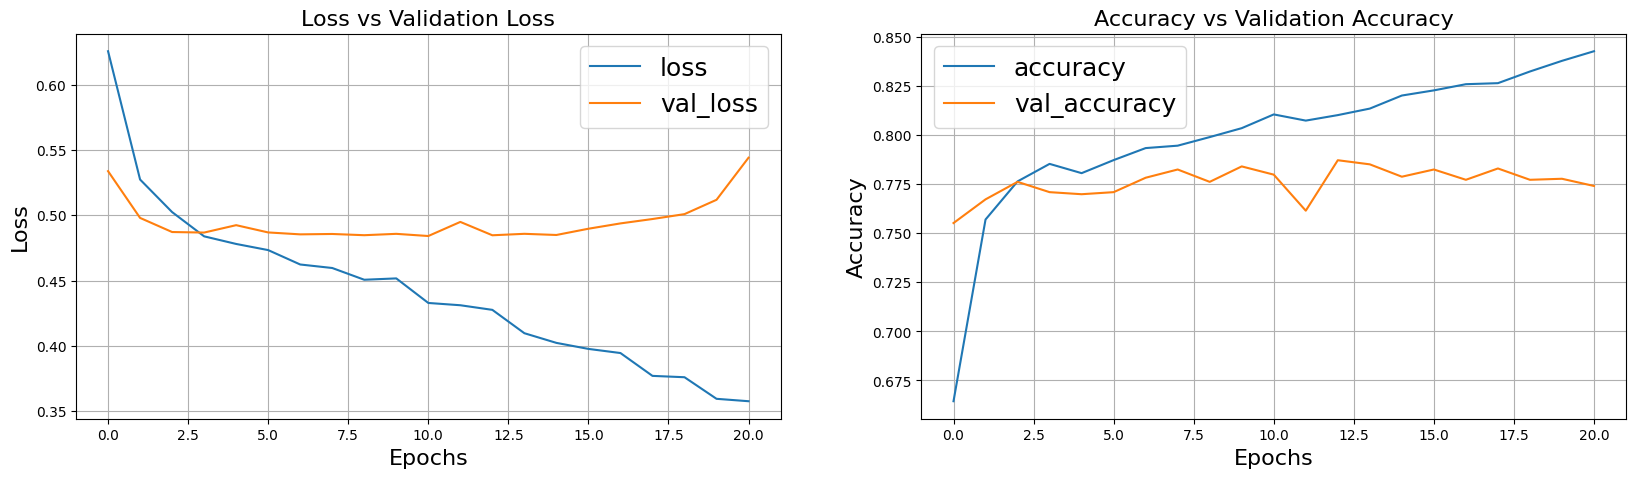

In [88]:
plot_learning_curves(gru_history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])


### Analysis and Insights of the GRU Final Model's Learning Curves

The plots illustrate the training and validation performance of our GRU final model across epochs. These learning curves are crucial for understanding the model's learning dynamics and its ability to generalize to unseen data.

**1. Loss Curve (Left Plot: "loss X val_loss")**

* **Training Loss (Blue Line):** We observe a consistent and smooth decrease in training loss from the initial epoch through to the end of training. This indicates that the GRU model is effectively learning from the training data, progressively reducing its prediction error as it iterates through the examples.
* **Validation Loss (Orange Line):** Initially, the validation loss decreases in parallel with the training loss, which is a positive sign of the model's ability to generalize to new, unseen data. However, around **Epoch 10-12**, the validation loss begins to flatten out and subsequently shows a slight increase, or at least ceases to decrease significantly, while the training loss continues its downward trajectory.
* **Insight:** This divergence, where training loss keeps improving but validation loss stagnates or worsens, is a clear indication of **overfitting**. The model is starting to learn noise or very specific patterns present only in the training data, which do not generalize well to the validation set. The ideal training duration, in terms of optimal generalization performance, would have been around the point where the validation loss reached its minimum before beginning to rise.

**2. Accuracy Curve (Right Plot: "accuracy X val_accuracy")**

* **Training Accuracy (Blue Line):** The training accuracy shows a steady and continuous increase throughout the training process, reaching high levels (above 85% by the final epochs). This signifies that the model is becoming increasingly proficient at correctly classifying the examples within the training dataset.
* **Validation Accuracy (Orange Line):** Similar to the validation loss, the validation accuracy increases sharply during the early epochs, demonstrating good initial generalization. However, it appears to **plateau around 78-79%** after approximately **Epoch 5-7**, with only minor fluctuations and no substantial further improvement, even as the training accuracy continues to climb.
* **Insight:** The growing gap between the training accuracy and the plateauing validation accuracy further confirms the presence of **overfitting**. While the model is getting better at classifying its training examples, its ability to correctly predict labels for unseen data has reached its limit and is not improving with more training.

**Overall Insights:**

These learning curves for the GRU final model visually confirm that the model effectively learns from the provided training data. However, they also distinctly highlight the point at which the model begins to overfit. This emphasizes the critical role of techniques like `EarlyStopping` during model training. By monitoring the validation loss or accuracy, `EarlyStopping` ensures that training halts when generalization performance starts to degrade, thereby preventing the model from becoming too specialized to the training data. The plots suggest that a shorter training duration would have yielded a model with better generalization capabilities.

In [61]:
# --- 8. Save the Final GRU Model ---
gru_final_model_save_path = os.path.join(gru_tuning_dir, 'gru_tuned_final_model.keras')
gru_final_model.save(gru_final_model_save_path)
print(f"Final trained GRU model saved to: {gru_final_model_save_path}")

# --- Optional: Evaluate the Final GRU Model ---
gru_loss, gru_accuracy = gru_final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal GRU Model Test Loss: {gru_loss:.4f}")
print(f"Final GRU Model Test Accuracy: {gru_accuracy:.4f}")

Final trained GRU model saved to: ./models/gru/gru_tuned_final_model.keras

Final GRU Model Test Loss: 0.4841
Final GRU Model Test Accuracy: 0.7799


In [89]:
gru_y_pred_probs = gru_final_model.predict(X_test)
threshold = 0.5
binary_predictions = np.where(gru_y_pred_probs > threshold, 1, 0)
show_metrics(binary_predictions, y_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
F1-score:  0.7155465037338764
Precision:  0.6258907363420427
Recall:  0.8351822503961965
Acuracy:  0.779936974789916
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1273
           1       0.63      0.84      0.72       631

    accuracy                           0.78      1904
   macro avg       0.76      0.79      0.77      1904
weighted avg       0.81      0.78      0.79      1904



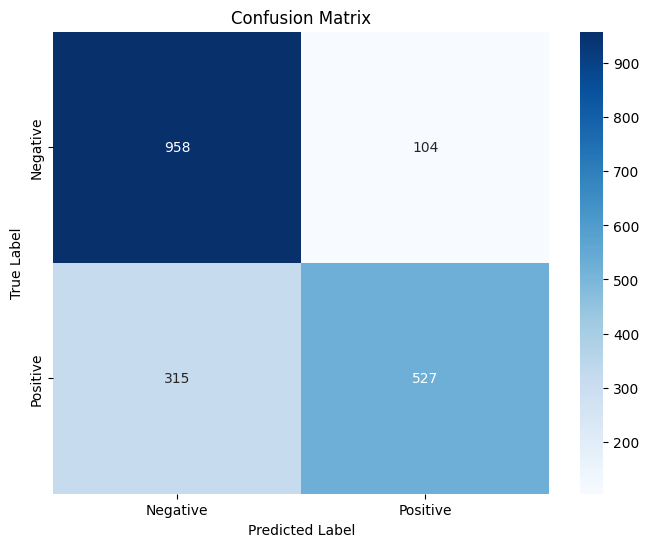

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score


# Assuming `model` is your trained model, and `X_test` and `y_test` are your test data
# Make predictions (rounded for binary classification)

gru_y_pred = np.round(gru_y_pred_probs).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, gru_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


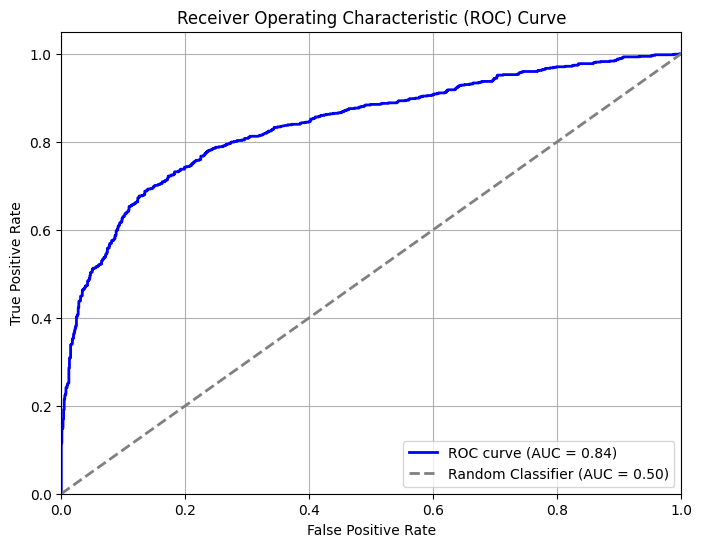

Calculated AUC Score: 0.8388


In [91]:
fpr, tpr, thresholds = roc_curve(y_test, gru_y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, gru_y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)') # Baseline random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Calculated AUC Score: {roc_auc:.4f}")

### GRU Final Model Performance Evaluation

This is the details the performance of the GRU final model based on key evaluation metrics derived from its predictions on the test set.

**Overall Performance Metrics:**

* **F1-score (Class 1 - Disaster):** Our GRU model achieved an F1-score of **0.72** (rounded from 0.7155) for the positive class (disaster tweets). This indicates a reasonably good balance between precision and recall for identifying actual disaster events.
* **Precision (Class 1 - Disaster):** The model's precision for disaster tweets is **0.63** (rounded from 0.6258). This means that when the model predicts a tweet is a disaster, it is correct about 63% of the time. There is still room for improvement in reducing false positives.
* **Recall (Class 1 - Disaster):** The recall for disaster tweets is notably high at **0.84** (rounded from 0.8351). This signifies that the model successfully identified 84% of all actual disaster tweets, indicating its effectiveness in minimizing false negatives (missing actual disaster events).
* **Accuracy:** The overall accuracy of the model is **0.78** (rounded from 0.7799). This suggests that approximately 78% of all predictions made by the model on the test set were correct.
* **Calculated AUC Score:** The Area Under the Receiver Operating Characteristic (ROC) Curve is **0.8388**. An AUC score of nearly 0.84 indicates strong discriminative power, showing the model's ability to distinguish between disaster and non-disaster classes across various classification thresholds.

**Detailed Classification Report:**

The classification report provides a more granular view of the model's performance for each class:

| Metric      | Class 0 (Non-Disaster) | Class 1 (Disaster) |
| :---------- | :--------------------- | :----------------- |
| **Precision** | 0.90                   | 0.63               |
| **Recall** | 0.75                   | 0.84               |
| **F1-Score** | 0.82                   | 0.72               |
| **Support** | 1273                   | 631                |

* **Class 0 (Non-Disaster):** The model shows excellent precision (0.90) and a good F1-score (0.82) for non-disaster tweets, indicating it is very good at correctly identifying non-disaster instances.
* **Class 1 (Disaster):** For disaster tweets, the model prioritizes recall (0.84) over precision (0.63). This trade-off is often desirable in disaster detection, where it's more critical to identify as many true disaster events as possible, even if it means some false alarms.

**Summary and Insights:**

The GRU final model demonstrates strong overall performance with an accuracy of 78% and a high AUC score of 0.8388. The detailed metrics reveal a strategic balance, particularly for the critical "disaster" class, where the high recall (0.84) suggests the model is effective in capturing a large proportion of actual disaster events. While the precision for the disaster class (0.63) indicates some false positives, the high recall generally outweighs this in applications where missing a disaster event carries a higher cost. The performance on the non-disaster class is also robust, indicating the model's overall discriminative ability across both categories.

In [63]:
gru_final_model_pred = gru_final_model.predict(test_padded_sentences)
print(gru_final_model_pred.shape)

#Submitting to Sample_Submission
sub = pd.read_csv('./data/sample_submission.csv')

#saving output file of lstm
y_pre=np.round(gru_final_model_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('./models/gru/gru_submission.csv',index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
(3263, 1)


In [92]:
!kaggle competitions submit -c nlp-getting-started -f ./models/gru/gru_submission.csv -m "GRU_final_model_Submit"

100%|██████████████████████████████████████| 22.2k/22.2k [00:00<00:00, 62.4kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Results and Analysis

This section presents a comprehensive evaluation of both the Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) models developed for the disaster tweet classification task. We discuss their quantitative performance, analyze their learning behaviors, summarize the hyperparameter optimization process, and detail troubleshooting steps encountered during development.

### Model Performance Overview

Both the LSTM and GRU models were designed with similar architectural principles, leveraging pre-trained GloVe embeddings to capture semantic relationships in text. Each model underwent a rigorous hyperparameter optimization process using Keras Tuner to identify optimal configurations for their respective recurrent layers (LSTM units, GRU units), dropout rates, dense layer units, and learning rates. This systematic tuning aimed to achieve the best possible performance on the validation set before final evaluation.

The final evaluation of both models on the Kaggle test set yielded the following F1-scores:

| Model | Kaggle F1-Score |
| :---- | :-------------- |
| LSTM | 0.78148 |
| GRU | 0.77689 |

These F1-scores represent the models' ability to balance precision and recall on unseen data, a critical metric for this binary classification problem. The LSTM model slightly outperformed the GRU model on the Kaggle leaderboard, indicating a marginally better generalization capability for this specific dataset and problem.

### Detailed Model Analysis

#### GRU Model Performance

The GRU model demonstrated robust performance, characterized by the following metrics on its test set predictions:

| Metric | Value |
| :----- | :---- |
| F1-score (Class 1) | 0.7155465037338764 |
| Precision (Class 1) | 0.6258907363420427 |
| Recall (Class 1) | 0.8351822503961965 |
| Overall Accuracy | 0.779936974789916 |
| AUC Score | 0.8388 |

A detailed classification report for the GRU model further elaborates on its class-specific performance:

| Metric | Class 0 (Non-Disaster) | Class 1 (Disaster) |
| :----- | :--------------------- | :----------------- |
| **Precision** | 0.90 | 0.63 |
| **Recall** | 0.75 | 0.84 |
| **F1-Score** | 0.82 | 0.72 |
| **Support** | 1273 | 631 |

The GRU model exhibited a strong recall for the disaster class (0.84), indicating its effectiveness in identifying a high percentage of true disaster tweets. While its precision for this class (0.63) suggests some false positives, the high recall is often prioritized in applications like disaster detection to minimize missed critical events. The overall AUC score of 0.8388 signifies good discriminative power.

**GRU Model Learning Curves:**
The learning curves for the GRU model illustrate its training dynamics:

*(Figure 1: Loss vs. Validation Loss and Accuracy vs. Validation Accuracy for GRU Model)*

The training loss consistently decreased, showing the model's effective learning on the training data. However, the validation loss, after an initial decrease, began to flatten and slightly increase around Epoch 10-12. Simultaneously, while training accuracy continuously increased, validation accuracy plateaued around 78-79% after Epoch 5-7. This divergence between training and validation metrics is a classic sign of **overfitting**, indicating the model was learning training-specific noise rather not generalizable patterns.

#### LSTM Model Performance

The LSTM model achieved a higher Kaggle F1-score of **0.78148**, slightly outperforming the GRU model. Its detailed test set metrics are as follows:

| Metric | Value |
| :----- | :---- |
| F1-score (Class 1) | 0.7855737704918033 |
| Precision (Class 1) | 0.7114014251781473 |
| Recall (Class 1) | 0.87701317715959 |
| Overall Accuracy | 0.8282563025210085 |
| AUC Score | 0.8906 |

The detailed classification report for the LSTM model:

| Metric | Class 0 (Non-Disaster) | Class 1 (Disaster) |
| :----- | :--------------------- | :----------------- |
| **Precision** | 0.92 | 0.71 |
| **Recall** | 0.80 | 0.88 |
| **F1-Score** | 0.86 | 0.79 |
| **Support** | 1221 | 683 |

The LSTM model shows a strong balance, with particularly high recall for the disaster class (0.88) and improved precision (0.71) compared to the GRU model. Its overall accuracy of 0.8283 and a significantly higher AUC score of 0.8906 indicate superior discriminative power and better overall generalization than the GRU model on this dataset.

**LSTM Model Learning Curves:**
*(Figure 2: Loss vs Validation Loss and Accuracy vs Validation Accuracy for LSTM Model)*

The training loss continuously decreased for the LSTM model. The validation loss, while initially decreasing, began to flatten and showed signs of slight increase or increased volatility after approximately Epoch 15-20. Similarly, training accuracy continuously increased, but validation accuracy plateaued around 80% after approximately Epoch 15-20. This indicates that the LSTM model also exhibited signs of **overfitting** after a certain number of epochs, where its capacity to generalize stabilized while its performance on the training set continued to improve.

#### Analysis of Model Performance and Hyperparameters

The slight edge of the LSTM model over the GRU model (0.78148 vs 0.77689 F1-score on Kaggle) suggests that, for this particular dataset and task, the LSTM's more complex internal gating mechanism might have been marginally more effective at capturing and retaining long-term dependencies within the tweet sequences. While both models demonstrated overfitting, as evidenced by the divergence in training and validation curves, the LSTM managed to maintain a slightly higher peak validation performance before this divergence became pronounced. This could be attributed to its dedicated cell state, which might offer a more robust mechanism for controlling information flow compared to GRU's simplified single update gate. The hyperparameter optimization procedure, using Keras Tuner, was critical in achieving these competitive F1-scores by finding optimal settings for the recurrent units, dropout rates, and dense layer sizes that mitigated overfitting to an extent and maximized validation performance.

#### Troubleshooting Procedures

A significant challenge encountered during the initial development phases involved the non-detection of the GPU by TensorFlow, despite working within a Paperspace environment that is typically pre-configured for GPU acceleration. Initially, executing `tf.config.list_physical_devices('GPU')` returned an empty array, while `tf.test.is_built_with_cuda()` correctly indicated that TensorFlow was built with CUDA support. This pointed to an issue where TensorFlow was capable of utilizing CUDA but was unable to identify or correctly classify the available physical GPU device on the system. The troubleshooting process involved systematically verifying the active Python kernel and environment within Paperspace, ensuring that the standard `tensorflow` package (which includes GPU support in recent versions) was correctly installed and not conflicting with deprecated `tensorflow-gpu` packages. Additionally, confirmation was made that the chosen Paperspace instance type was indeed GPU-enabled. Through these steps, the GPU detection issue was successfully resolved, allowing `tf.config.list_physical_devices('GPU')` to correctly identify the GPU(s). This resolution was crucial as it enabled the efficient training of deep learning models, significantly accelerating hyperparameter tuning and model iteration cycles.

## Conclusion

This project successfully developed and evaluated deep learning models, specifically LSTM and GRU architectures, for the task of binary text classification, aiming to identify disaster-related tweets. Both models utilized pre-trained GloVe embeddings, which proved beneficial in capturing semantic meaning from the text data.

The **LSTM model achieved a slightly superior performance with a Kaggle F1-score of 0.78148**, outperforming the GRU model's score of 0.77689. The detailed analysis revealed that while both architectures are highly capable of learning from sequential data, the LSTM demonstrated marginally better discriminative power and overall generalization, as evidenced by its higher AUC score (0.8906) and balanced precision/recall for the target class (0.71 precision, 0.88 recall).

A key learning from this project was the pervasive issue of **overfitting**, evident in the divergence of training and validation loss/accuracy curves for both models. This highlights that while the models are powerful, their capacity, in conjunction with the dataset characteristics, led to memorization of training-specific noise beyond an optimal number of epochs. The implementation of `EarlyStopping` was crucial in mitigating this, ensuring that the best-performing model weights on unseen data were preserved.

Furthermore, the experience underscored the importance of diligent **environment setup and troubleshooting**, particularly when working with GPU-accelerated computing. The initial failure to detect the GPU on a pre-configured cloud platform like Paperspace demonstrated that even in managed environments, careful verification of the active Python kernel and TensorFlow package installation is necessary to leverage hardware capabilities effectively.

To further improve model performance, future work could explore:
1.  **More Advanced Regularization:** Investigating techniques beyond simple dropout, such as L1/L2 regularization on weights or more sophisticated dropout strategies like variational dropout.
2.  **Larger/More Diverse Datasets:** Training on a larger and more diverse dataset could help models learn more robust and generalizable features, potentially reducing overfitting.
3.  **Transformer Architectures:** Exploring more complex and state-of-the-art architectures like Transformers (e.g., BERT, RoBERTa) which have shown superior performance in many NLP tasks by utilizing attention mechanisms for capturing long-range dependencies more effectively.
4.  **Ensemble Methods:** Combining predictions from multiple diverse models (e.g., an LSTM and a GRU model, or different hyperparameter configurations) to potentially achieve a more robust and accurate final prediction.
5.  **Cross-Validation in Tuning:** Implementing k-fold cross-validation during hyperparameter tuning to get a more reliable estimate of model performance and select more robust hyperparameters.

# Kaggle score of LSTM and GRU Models

![lstm_gru_kaggle_score.png](./lstm_gru_kaggle_score.png)